In [1]:
import pydwf
import pydwf.utilities
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import butter, lfilter
import datetime
from pathlib import Path

%matplotlib widget

## Helper functions

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

## Open device

In [3]:
## Open device
dwf = pydwf.DwfLibrary()
dev = dwf.deviceControl.open(-1)

## Setup output settings

In [4]:
## Analog output settings
outCH = [0]
outData = np.array([1, 0])
n_data = len(outData)
outFreq = 80e3 / n_data
outTRun = 1 / outFreq
outTWait = 0 / outFreq
outRepeat = 1

## Setup analogOut
anOut = dev.analogOut
node = pydwf.DwfAnalogOutNode.Carrier
for CH in outCH:
    anOut.reset(CH)
    anOut.nodeEnableSet(CH, node, True)
    anOut.nodeFunctionSet(CH, node, pydwf.DwfAnalogOutFunction.Custom)
    anOut.nodeFrequencySet(CH, node, outFreq)
    anOut.nodeAmplitudeSet(CH, node, 5)
    anOut.idleSet(CH, pydwf.DwfAnalogOutIdle.Disable)
    anOut.runSet(CH, outTRun)
    anOut.waitSet(CH, outTWait)
    anOut.repeatSet(CH, outRepeat)
    anOut.triggerSourceSet(CH, pydwf.DwfTriggerSource.PC)
    anOut.nodeDataSet(CH, node, outData)

## Setup input settings

In [17]:
## Analog input settings
inCH = [0, 1]
inFreq = 1e6
inRecordLen = 0.004
inNSamples = int(inFreq * inRecordLen)

## Setup analogIn
anIn = dev.analogIn
anIn.reset()
for CH in inCH:
    anIn.channelEnableSet(CH, True)
anIn.acquisitionModeSet(pydwf.DwfAcquisitionMode.Record)
anIn.frequencySet(inFreq)
anIn.recordLengthSet(inRecordLen)
anIn.triggerSourceSet(pydwf.DwfTriggerSource.PC)
time.sleep(2)  # Sleep to allow offset to stabilize

## Read data

228.45%  8192      9138


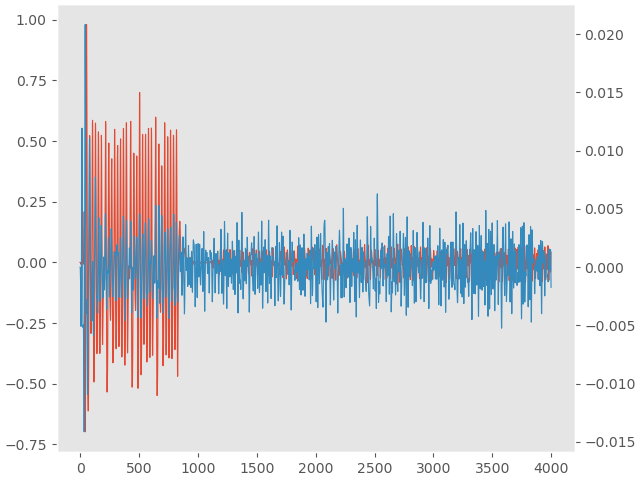

In [31]:
plt.close()
fig, axs = plt.subplots(1, 1, sharex=True)
runs = []

## Start analogOut and analogIn
anOut.configure(-1, 1)
anIn.configure(True, True)
dev.triggerPC()  # Send trigger signal

## Read data from analogIn
samples = []
while True:
    status = anIn.status(True)
    if status in [pydwf.DwfState.Armed, pydwf.DwfState.Ready]:
        continue
    aSamples, _, _ = anIn.statusRecord()

    if aSamples != 0:
        cSamples = np.vstack(
                    [anIn.statusData(idx, aSamples)
                     for idx in inCH]).transpose()
        samples.append(cSamples)

    nSamples = sum(len(x) for x in samples)
    print(f"\r\033[K{100*nSamples/inNSamples: >4.2f}% {aSamples: >5} {nSamples: >9}", end="")

    if status == pydwf.DwfState.Done and nSamples >= inNSamples:
        break
print()

## Concatenate all sample chunks
samples = np.concatenate(samples)

## Discard oldest samples
samples = samples[-inNSamples:]

inSig = samples[:, 0]
outSig = butter_bandpass_filter(samples[:, 1], 20e3, 80e3, inFreq)
# outSig = butter_bandpass_filter(samples[:, 1], 20e3, 250e3, inFreq)
# outSig = samples[:, 1]

axs.plot(butter_bandpass_filter(inSig, 20e3, 80e3, inFreq), c="C0")
axr = axs.twinx()
axr.plot(outSig, c="C1")
axs.grid(False)
axr.grid(False)

# now = datetime.datetime.now()
# out_path = Path("data", f"{now:%y%m%d}", f"data_VERO_{now:%H%M%S}.csv")
# out_path.parent.mkdir(exist_ok=True)
# np.savetxt(out_path, samples, delimiter=",")

## Close device

In [32]:
dev.close()